## 📌 LSTM 모델을 이용한 YG 주가 예측

### 사용변수 : 주식데이터 , 기술적보조지표, 트렌드, 이벤트, 감성지수 

In [1]:
#!pip install torchvision

In [2]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [3]:
plt.style.use('seaborn-whitegrid')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [4]:
#!pip install yfinance

## 1. 데이터 형태 확인

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv("../../../../data/FINALDATA/yg.csv")
date=df['DATE']
df.set_index('DATE',inplace=True)
df

,Open,High,Low,Close,Volume,Change,MACD,Signal,PSAR,upper,...,OBV,FI,keyword,view_log_like_sum,view_log_like_avg,count,trend,DAY,SENTIMENT,EVENT
DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-02,46550.0,49000.0,45950.0,48050.0,1483247.0,0.095781,686.685188,731.113168,42450.000000,47632.663771,...,2124425.0,6.229637e+09,69.27633,1.533087e+07,3.832717e+06,4.000000,19.386937,월,126.027702,28.548385
2023-01-03,47500.0,50800.0,47500.0,49500.0,1176815.0,0.030177,977.776846,780.445904,42450.000000,48489.364345,...,3301240.0,1.706382e+09,60.65854,0.000000e+00,0.000000e+00,0.000000,4.105260,화,119.020563,-33.331533
2023-01-04,49800.0,50000.0,48350.0,48800.0,505379.0,-0.014141,1138.856898,852.128103,42784.000000,49006.708184,...,2795861.0,-3.537653e+08,53.81251,2.069984e+06,5.174959e+05,4.000000,17.786657,수,209.513567,74.965736
2023-01-05,49250.0,50100.0,48250.0,49100.0,445150.0,0.006148,1276.012416,936.904965,43104.640000,49529.032241,...,3241011.0,1.335450e+08,51.66778,0.000000e+00,0.000000e+00,0.000000,3.944834,목,277.915244,NaN
2023-01-06,48700.0,49900.0,46950.0,49600.0,580137.0,0.010183,1408.815031,1031.286979,43412.454400,50068.227039,...,3821148.0,2.900685e+08,45.43369,3.521540e+07,5.869234e+06,6.000000,20.174104,금,269.611104,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,77600.0,78700.0,76600.0,77200.0,219672.0,-0.010256,-274.988847,1400.729619,83589.187649,96365.688093,...,10771841.0,-1.757376e+08,36.15345,2.534873e+06,2.534873e+06,0.333333,8.930417,월,282.396226,NaN
2023-06-27,76800.0,80400.0,76500.0,78900.0,438592.0,0.022021,-454.030222,1029.777651,82191.350119,95568.728434,...,11210433.0,7.456064e+08,36.76734,3.616425e+07,1.808213e+07,2.000000,20.754231,화,NaN,NaN
2023-06-28,80000.0,80200.0,78100.0,78500.0,246068.0,-0.005070,-621.039502,699.614220,81053.080095,93869.355650,...,10964365.0,-9.842720e+07,37.15977,6.728249e+08,3.364125e+08,2.000000,23.688262,수,NaN,NaN


In [6]:
df.isna().sum()

Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
Change                 0
MACD                   0
Signal                 0
PSAR                   0
upper                  0
middle                 0
lower                  0
SlowK                  0
SlowD                  0
ROC                    0
OBV                    0
FI                     0
keyword                0
view_log_like_sum      0
view_log_like_avg      0
count                  0
trend                  0
DAY                    0
SENTIMENT              4
EVENT                106
dtype: int64

In [7]:
df.loc[df['Close'].isna()]

,Open,High,Low,Close,Volume,Change,MACD,Signal,PSAR,upper,...,OBV,FI,keyword,view_log_like_sum,view_log_like_avg,count,trend,DAY,SENTIMENT,EVENT
DATE,,,,,,,,,,,,,,,,,,,,,


In [8]:
# df.drop(index='2023-05-05',inplace=True)

In [9]:
df.fillna(0,inplace=True)
df.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume               0
Change               0
MACD                 0
Signal               0
PSAR                 0
upper                0
middle               0
lower                0
SlowK                0
SlowD                0
ROC                  0
OBV                  0
FI                   0
keyword              0
view_log_like_sum    0
view_log_like_avg    0
count                0
trend                0
DAY                  0
SENTIMENT            0
EVENT                0
dtype: int64

In [10]:
drop_columns=['Close','view_log_like_sum','view_log_like_avg','count','DAY','keyword']

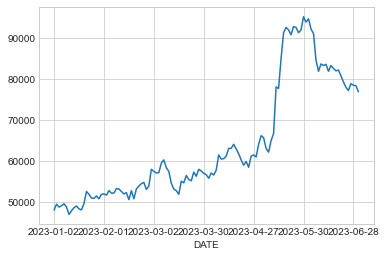

In [11]:
fig = df['Close'].plot()

In [12]:
X = df.drop(drop_columns, axis=1) # X, y 분리
y = df[['Close']]

In [13]:
X.fillna(0,inplace=True)
X.isna().sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 2023-01-02 to 2023-06-30
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       123 non-null    float64
 1   High       123 non-null    float64
 2   Low        123 non-null    float64
 3   Volume     123 non-null    float64
 4   Change     123 non-null    float64
 5   MACD       123 non-null    float64
 6   Signal     123 non-null    float64
 7   PSAR       123 non-null    float64
 8   upper      123 non-null    float64
 9   middle     123 non-null    float64
 10  lower      123 non-null    float64
 11  SlowK      123 non-null    float64
 12  SlowD      123 non-null    float64
 13  ROC        123 non-null    float64
 14  OBV        123 non-null    float64
 15  FI         123 non-null    float64
 16  trend      123 non-null    float64
 17  SENTIMENT  123 non-null    float64
 18  EVENT      123 non-null    float64
dtypes: float64(19)
memory usage: 19.2+ KB


## 2. 8:2 로 train test 분리

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:99, :] # 이부분 확인해보기!!!!!!!!!!!!!!!!!!!!
X_test = X_ss[99:, :]

y_train = y_ms[:99, :]
y_test = y_ms[99:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (99, 19) (99, 1)
Testing Shape : (24, 19) (24, 1)


In [15]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (99, 19) (99, 1)
Testing Shape : (24, 19) (24, 1)


## 3. LSTM 모델 설정

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout_prob=0.0):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer added
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying dropout before the final fully connected layer
        out = self.fc(out)
        return out


In [17]:
num_epochs = 2000
learning_rate = 0.0009

input_size=19 # 칼럼 개수
hidden_size=25 # 은닉층 유닛 개수
num_layers=1 # LSTM 계층 개수
dropout_prob = 0.3

num_classes=1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 오차 계싼
    loss.backward() # 기울기 계산
    
    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.08059
Epoch : 100, loss : 0.00020
Epoch : 200, loss : 0.00007
Epoch : 300, loss : 0.00003
Epoch : 400, loss : 0.00002
Epoch : 500, loss : 0.00001
Epoch : 600, loss : 0.00001
Epoch : 700, loss : 0.00001
Epoch : 800, loss : 0.00001
Epoch : 900, loss : 0.00001
Epoch : 1000, loss : 0.00000
Epoch : 1100, loss : 0.00000
Epoch : 1200, loss : 0.00000
Epoch : 1300, loss : 0.00000
Epoch : 1400, loss : 0.00000
Epoch : 1500, loss : 0.00000
Epoch : 1600, loss : 0.00000
Epoch : 1700, loss : 0.00000
Epoch : 1800, loss : 0.00000
Epoch : 1900, loss : 0.00000


In [19]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

## 4. 예측된 주식 값과 실제 주식 값을 시각화

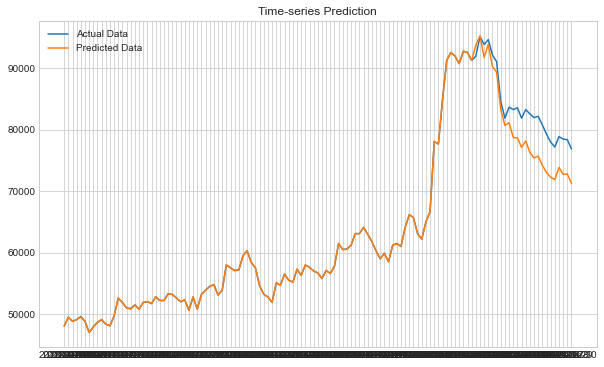

In [20]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
# plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 5. RMSE 계산

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 예측값과 실제값을 NumPy 배열로 변환
predicted = np.array(df['pred'])
actual = np.array(df['Close'])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse}')


RMSE: 2029.0467733191817


## 6. 데이터 내보내기

In [22]:
YG_ALL_LSTM=pd.DataFrame({'DATE':date,'predicted':predicted,'actual':actual})
YG_ALL_LSTM.set_index('DATE',inplace=True)
YG_ALL_LSTM.to_csv('../../../../result/yg/[LSTM] YG.csv',sep=',')
YG_ALL_LSTM

,predicted,actual
DATE,,
2023-01-02,48049.281250,48050.0
2023-01-03,49501.828125,49500.0
2023-01-04,48801.531250,48800.0
2023-01-05,49111.511719,49100.0
2023-01-06,49507.246094,49600.0
...,...,...
2023-06-26,71885.445312,77200.0
2023-06-27,73877.468750,78900.0
2023-06-28,72764.164062,78500.0
